## Comparing inside-model scaling with outside (dataset) scaling
This notebook uses avg and loo models with within-model scaling and out-of-model scaling.
Scaling is standardizing X with `parcel` / `global` mode and cerebellum with `global` mode.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.run_model as rm
import matplotlib.pyplot as plt

In [2]:
# Load inside-model scaling evaluation
df_in = pd.read_csv('../../data/Nettekoven2024_model_evaluations.tsv',sep='\t')
df_in = df_in[df_in['train_dataset']!='HCP']

In [3]:
# Load outside-model scaling evaluation
method = 'L2reg'
dataset_list = ["MDTB", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
df_out = pd.DataFrame()
for dataset_name in dataset_list:
    eval_data = [eval_ds for eval_ds in dataset_list if eval_ds != dataset_name]

    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avg"],methods=[method],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-avg"
    df_out = pd.concat([df_out, df], ignore_index=True)

    # Load loo performances
    df = rm.comb_eval(models=[dataset_name+"-loo"],methods=[method],eval_data=[dataset_name],cerebellum='MNISymC3')
    df['model'] = dataset_name+"-loo"
    df_out = pd.concat([df_out, df], ignore_index=True)

### get best alpha for each model

In [4]:
A = pd.pivot_table(df_out,index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean')
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
df_out['isbest'] = df_out.logalpha.values == bestla.loc[df_out.train_dataset].values.flatten()
df_out = df_out[((df_out.train_dataset!=df_out.eval_dataset) | (df_out.model.str.contains('loo'))) & df_out.isbest].reset_index(drop=True)

### Evaluation heatmap

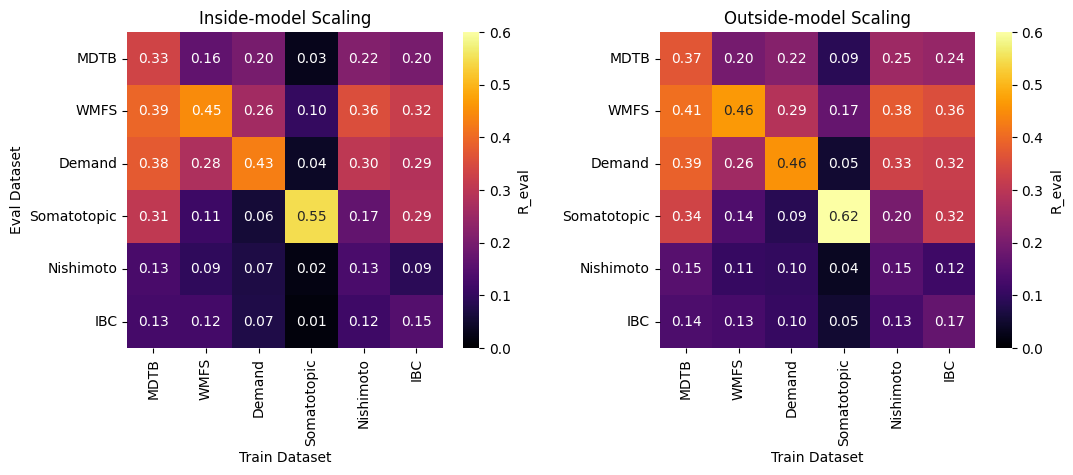

In [11]:
fig, axes = plt.subplots(1,2,figsize=(11,4.5))
for i, df_to_plot in enumerate([df_in, df_out]):
    V = pd.pivot_table(df_to_plot, columns=['train_dataset'], index=['eval_dataset'], values=['R_eval'])
    V = V.reindex(dataset_list, axis=0)
    V = V.reindex(dataset_list, level=1, axis=1)
    
    plt.subplot(1,2,i+1)
    sns.heatmap(V.values, annot=True, fmt=".2f", cmap='inferno', vmin=0, vmax=0.6, 
                xticklabels=V.columns.get_level_values(1).values, 
                yticklabels=V.index.values, cbar_kws={'label': 'R_eval'}, square=True)

    if i==0:
        plt.title('Inside-model Scaling')
        plt.ylabel('Eval Dataset')
    else:
        plt.title('Outside-model Scaling')
    plt.xlabel('Train Dataset')
    
plt.tight_layout()